In [489]:
import matplotlib.pyplot as plt
import math

In [490]:
lencable = 20.5
cablespan = 20
Larm = .25
dap = .25 * Larm
dpdp = .75* Larm
dp = .5
g = 9.8
mshuttle = 16


In [390]:
maxcablespan = 20
measured_dcable = lencable - cablespan

In [391]:
import numpy as np

In [493]:
miny = 0.5
mintakeup = maxcablespan + measured_dcable-math.sqrt(maxcablespan**2+4*miny**2)
mintakeup

0.4750156054992125

In [494]:
def get_needed_takeup_angles(mintakeup):
        return math.acos((1/(128*dpdp**2*Larm**2))*(-Larm*mintakeup*(128*dap*dpdp+64*dpdp**2+32*dap*mintakeup+16*dpdp*mintakeup)+(math.sqrt)(Larm**2*mintakeup**2*(128*dap*dpdp+64*dpdp**2+32*dap*mintakeup+16*dpdp*mintakeup)**2-256*dpdp**2*Larm**2*(-64*dpdp**2*Larm**2-64*dap**2*dpdp*mintakeup-64*dap*dpdp**2*mintakeup-64*dpdp*Larm**2*mintakeup-16*dap**2*mintakeup**2-16*dap*dpdp*mintakeup**2+16*dpdp**2*mintakeup**2-16*Larm**2*mintakeup**2+8*dpdp*mintakeup**3+mintakeup**4))))
    
def get_needed_takeup_angle(mintakeup):
    return math.acos((1/(8*dpdp**2*Larm**2))*(-Larm*(16*dap**3+24*dap**2*dpdp+40*dap*dpdp**2+16*dpdp**3-32*dap*dpdp*math.sqrt((dap-Larm)**2)-16*dpdp**2*math.sqrt((dap-Larm)**2)-32*dap*dpdp*math.sqrt((dap+dpdp-Larm)**2)-16*dpdp**2*math.sqrt((dap+dpdp-Larm)**2)+16*dap*math.sqrt((dap-Larm)**2)*math.sqrt((dap+dpdp-Larm)**2)+8*dpdp*math.sqrt((dap-Larm)**2)*math.sqrt((dap+dpdp-Larm)**2)-32*dap**2*Larm-32*dap*dpdp*Larm-8*dpdp**2*Larm+16*dap*Larm**2+8*dpdp*Larm**2+32*dap*dpdp*mintakeup+16*dpdp**2*mintakeup-16*dap*math.sqrt((dap-Larm)**2)*mintakeup-8*dpdp*math.sqrt((dap-Larm)**2)*mintakeup-16*dap*math.sqrt((dap+dpdp-Larm)**2)*mintakeup-8*dpdp*math.sqrt((dap+dpdp-Larm)**2)*mintakeup+8*dap*mintakeup**2+4*dpdp*mintakeup**2)+(math.sqrt)(Larm**2*(16*dap**3+24*dap**2*dpdp+40*dap*dpdp**2+16*dpdp**3-32*dap*dpdp*math.sqrt((dap-Larm)**2)-16*dpdp**2*math.sqrt((dap-Larm)**2)-32*dap*dpdp*math.sqrt((dap+dpdp-Larm)**2)-16*dpdp**2*math.sqrt((dap+dpdp-Larm)**2)+16*dap*math.sqrt((dap-Larm)**2)*math.sqrt((dap+dpdp-Larm)**2)+8*dpdp*math.sqrt((dap-Larm)**2)*math.sqrt((dap+dpdp-Larm)**2)-32*dap**2*Larm-32*dap*dpdp*Larm-8*dpdp**2*Larm+16*dap*Larm**2+8*dpdp*Larm**2+32*dap*dpdp*mintakeup+16*dpdp**2*mintakeup-16*dap*math.sqrt((dap-Larm)**2)*mintakeup-8*dpdp*math.sqrt((dap-Larm)**2)*mintakeup-16*dap*math.sqrt((dap+dpdp-Larm)**2)*mintakeup-8*dpdp*math.sqrt((dap+dpdp-Larm)**2)*mintakeup+8*dap*mintakeup**2+4*dpdp*mintakeup**2)**2-16*dpdp**2*Larm**2*(32*dap**2*dpdp**2+32*dap*dpdp**3+32*dpdp**4-16*dap**2*dpdp*math.sqrt((dap-Larm)**2)-32*dap*dpdp**2*math.sqrt((dap-Larm)**2)-48*dpdp**3*math.sqrt((dap-Larm)**2)-16*dap**2*dpdp*math.sqrt((dap+dpdp-Larm)**2)-32*dpdp**3*math.sqrt((dap+dpdp-Larm)**2)+48*dpdp**2*math.sqrt((dap-Larm)**2)*math.sqrt((dap+dpdp-Larm)**2)-16*dap**3*Larm-24*dap**2*dpdp*Larm-104*dap*dpdp**2*Larm-48*dpdp**3*Larm+64*dap*dpdp*math.sqrt((dap-Larm)**2)*Larm+48*dpdp**2*math.sqrt((dap-Larm)**2)*Larm+64*dap*dpdp*math.sqrt((dap+dpdp-Larm)**2)*Larm+16*dpdp**2*math.sqrt((dap+dpdp-Larm)**2)*Larm-16*dap*math.sqrt((dap-Larm)**2)*math.sqrt((dap+dpdp-Larm)**2)*Larm-8*dpdp*math.sqrt((dap-Larm)**2)*math.sqrt((dap+dpdp-Larm)**2)*Larm+32*dap**2*Larm**2+32*dap*dpdp*Larm**2+36*dpdp**2*Larm**2-16*dpdp*math.sqrt((dap-Larm)**2)*Larm**2-16*dpdp*math.sqrt((dap+dpdp-Larm)**2)*Larm**2-16*dap*Larm**3-8*dpdp*Larm**3+32*dap**2*dpdp*mintakeup+32*dap*dpdp**2*mintakeup+48*dpdp**3*mintakeup-8*dap**2*math.sqrt((dap-Larm)**2)*mintakeup-16*dap*dpdp*math.sqrt((dap-Larm)**2)*mintakeup-56*dpdp**2*math.sqrt((dap-Larm)**2)*mintakeup-8*dap**2*math.sqrt((dap+dpdp-Larm)**2)*mintakeup-48*dpdp**2*math.sqrt((dap+dpdp-Larm)**2)*mintakeup+48*dpdp*math.sqrt((dap-Larm)**2)*math.sqrt((dap+dpdp-Larm)**2)*mintakeup-96*dap*dpdp*Larm*mintakeup-48*dpdp**2*Larm*mintakeup+32*dap*math.sqrt((dap-Larm)**2)*Larm*mintakeup+24*dpdp*math.sqrt((dap-Larm)**2)*Larm*mintakeup+32*dap*math.sqrt((dap+dpdp-Larm)**2)*Larm*mintakeup+8*dpdp*math.sqrt((dap+dpdp-Larm)**2)*Larm*mintakeup+32*dpdp*Larm**2*mintakeup-8*math.sqrt((dap-Larm)**2)*Larm**2*mintakeup-8*math.sqrt((dap+dpdp-Larm)**2)*Larm**2*mintakeup+8*dap**2*mintakeup**2+8*dap*dpdp*mintakeup**2+28*dpdp**2*mintakeup**2-24*dpdp*math.sqrt((dap-Larm)**2)*mintakeup**2-24*dpdp*math.sqrt((dap+dpdp-Larm)**2)*mintakeup**2+12*math.sqrt((dap-Larm)**2)*math.sqrt((dap+dpdp-Larm)**2)*mintakeup**2-24*dap*Larm*mintakeup**2-12*dpdp*Larm*mintakeup**2+8*Larm**2*mintakeup**2+8*dpdp*mintakeup**3-4*math.sqrt((dap-Larm)**2)*mintakeup**3-4*math.sqrt((dap+dpdp-Larm)**2)*mintakeup**3+mintakeup**4)))) 


In [495]:
min_a = get_needed_takeup_angles(mintakeup)
min_a

0.867278770612159

In [499]:
max_a = get_needed_takeup_angle(mintakeup)
max_a

1.7987319215928188

In [500]:
relative_slope = get_needed_takeup_angles(mintakeup) / (get_needed_takeup_angles(mintakeup) - max_a)
relative_slope

-0.931102943501843

In [501]:
stake_transition_dist = 0.08

In [502]:
import math
def func(t, x, u):
    u1, u2, u3 = u
    x1, x2, x3, x4, x5, x6, x7, x8 = x
    #print(x4)
    dx3 = (2*Larm**2*u1*math.cos(x1)*math.sin(x1)+2*Larm*u1*(dap+dpdp-Larm*math.cos(x1))*math.sin(x1))/(2*math.sqrt((dap+dpdp-Larm*math.cos(x1))**2+Larm**2*math.sin(x1)**2))+(2*Larm**2*u1*math.cos(x1)*math.sin(x1)-2*Larm*u1*(-dap+Larm*math.cos(x1))*math.sin(x1))/(2*math.sqrt((-dap+Larm*math.cos(x1))**2+Larm**2*math.sin(x1)**2))+(2*Larm**2*u2*math.cos(x2)*math.sin(x2)+2*Larm*u2*(dap+dpdp-Larm*math.cos(x2))*math.sin(x2))/(2*math.sqrt((dap+dpdp-Larm*math.cos(x2))**2+Larm**2*math.sin(x2)**2))+(2*Larm**2*u2*math.cos(x2)*math.sin(x2)-2*Larm*u2*(-dap+Larm*math.cos(x2))*math.sin(x2))/(2*math.sqrt((-dap+Larm*math.cos(x2))**2+Larm**2*math.sin(x2)**2))
    dx5 = (2*dx3*(lencable-x3)+2*u3*(lencable-x3)-2*dx3*x4)/(2*cablespan)
    dx6 = (2*u3*x4-((2*dx3*(lencable-x3)+2*u3*(lencable-x3)-2*dx3*x4)*(cablespan**2-(lencable-x3)**2+2*(lencable-x3)*x4))/(2*cablespan**2))/(2*math.sqrt(x4**2-(cablespan**2-(lencable-x3)**2+2*(lencable-x3)*x4)**2/(4*cablespan**2)))
    dx7 = -((dx6*g*mshuttle*x4*(cablespan-x5))/(cablespan*x6**2))-(dx5*g*mshuttle*x4)/(cablespan*x6)+(g*mshuttle*u3*(cablespan-x5))/(cablespan*x6)
    dx8 = (dx6*(-g*lencable*mshuttle*x5+g*mshuttle*x3*x5+g*mshuttle*x4*x5))/(cablespan*x6**2)-(-dx5*g*lencable*mshuttle+dx5*g*mshuttle*x3+dx5*g*mshuttle*x4+dx3*g*mshuttle*x5+g*mshuttle*u3*x5)/(cablespan*x6)
    return np.array([u1, u2, dx3, u3, dx5, dx6, dx7, dx8])

In [503]:
from scipy.integrate import RK45
max_angle = math.pi * 8/9
raised = False
max_tension = 0

non_increasing_count = 0
target_tension = -1000000
def get_output(x):
    global raised, max_tension, non_increasing_count, target_tension
    larm, rarm, takeup, dist, x, y, tl, tr = x
    lout = 0
    rout = 0
    v = 0
    if not raised:
        if larm < min_a:
            lout = .1
        if rarm > min_a:
            rout = -.1
        if larm >= min_a and rarm <= min_a:
            raised = True
    if raised:
        
        v = 1
        if x >= cablespan - (stake_transition_dist + dpdp + dap + dp/2):
            v = 0
            if larm < max_a:
                lout = -relative_slope
            if rarm > 0:
                rout = relative_slope
            if larm >= max_a and rarm <= 0:
                v = 1
            

    #print(lout, rout, v)
    return np.array([lout, rout, v])

def get_start_array(larm, rarm):
    
    takeup = (-2*dpdp+math.sqrt((dap+dpdp-Larm*math.cos(larm))**2+Larm**2*math.sin(larm)**2)+math.sqrt((-dap+Larm*math.cos(larm))**2+Larm**2*math.sin(larm)**2)+math.sqrt((dap+dpdp-Larm*math.cos(rarm))**2+Larm**2*math.sin(rarm)**2)+math.sqrt((-dap+Larm*math.cos(rarm))**2+Larm**2*math.sin(rarm)**2))
    print(lencable - takeup)
    poscable = max(((lencable - takeup)**2 - cablespan**2)/(2 * (lencable - takeup)), stake_transition_dist + dpdp + dap + dp/2)
    print(poscable)
    print((poscable**2-(cablespan**2+2*poscable*(lencable-takeup)-(lencable-takeup)**2)**2/(4*cablespan**2)))
    x = (cablespan**2+2*poscable*(lencable-takeup)-(lencable-takeup)**2)/(2*cablespan) 
    y = math.sqrt(poscable**2-(cablespan**2+2*poscable*(lencable-takeup)-(lencable-takeup)**2)**2/(4*cablespan**2))
    tl = (g*mshuttle*poscable*(cablespan-x))/(cablespan*y)
    tr = -((-g*lencable*mshuttle*x+g*mshuttle*poscable*x+g*mshuttle*takeup*x)/(cablespan*y))
    return np.array([larm, rarm, takeup, poscable, x, y, tl, tr])
    

In [504]:
sim_time = 1000
sim_step_time = 0.02
left_arm_start_angle = 0.00001
right_arm_start_angle = max_a

max_dist = .5 * (lencable + cablespan)
print(max_dist)
start_state = get_start_array(left_arm_start_angle, right_arm_start_angle)
print(start_state)
integrator = RK45(lambda t, x: func(t, x, get_output(x)), 0, start_state, sim_time, sim_step_time)
time = []

output = np.zeros((0, 8))
for step in range(int(sim_time / sim_step_time)):
    
    try:
        integrator.step()
        pass
    except ValueError as e:
        print(integrator.y)
        print(f"Sim step failed, exiting: at {integrator.y[3]}")
        break
    
    output = np.append(output,[integrator.y],axis= 0)
    time.append(integrator.t)
    


    

20.25
20.02498189449662
0.5800000000000001
0.027567525848000818
[1.00000000e-05 1.79873192e+00 4.75018106e-01 5.80000000e-01
 5.55726978e-01 1.66034713e-01 5.32521163e+02 5.10253733e+02]
[ 1.79965742e+00 -5.26955906e-04  4.75080006e-01  1.99932943e+01
  1.99932704e+01  3.07815475e-02  3.95000550e+01  1.66308698e+02]
Sim step failed, exiting: at 19.993294301088223


(19.0, 20.0)

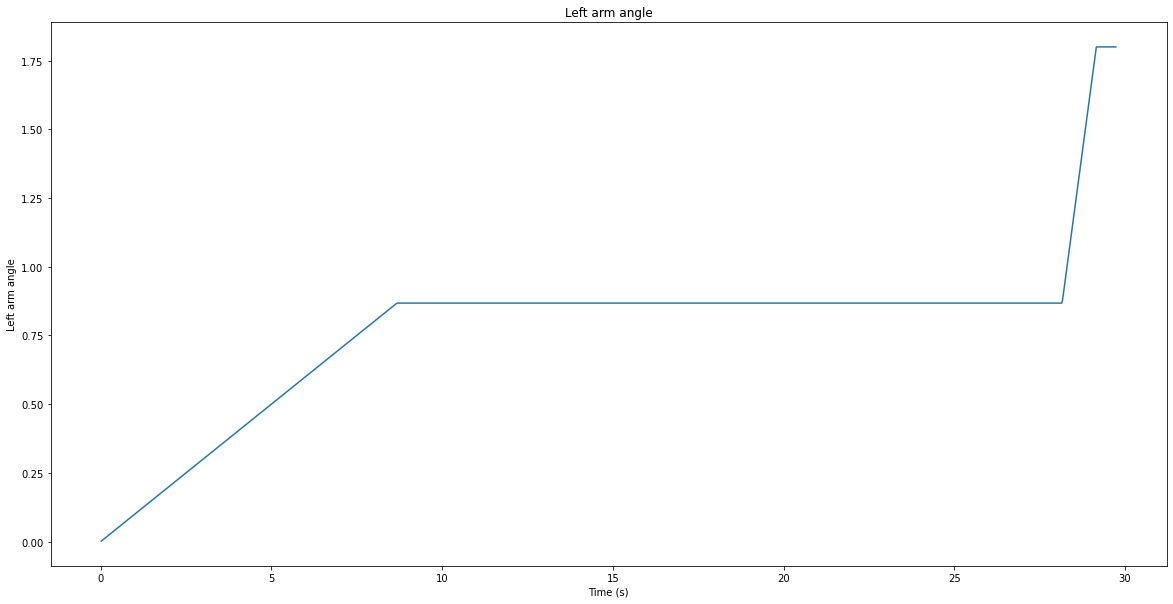

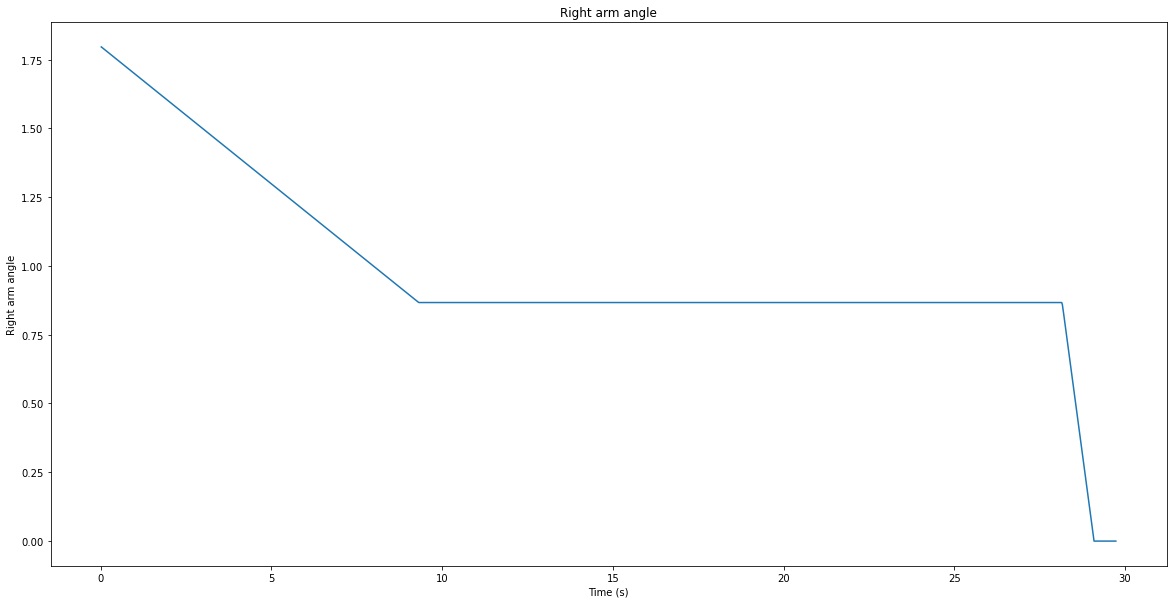

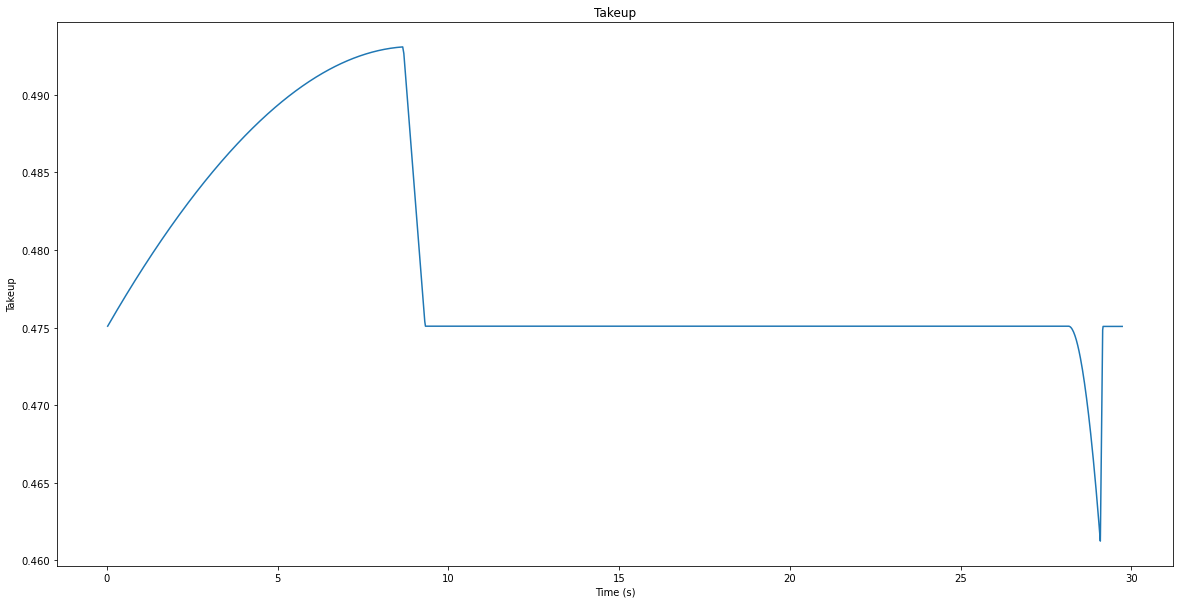

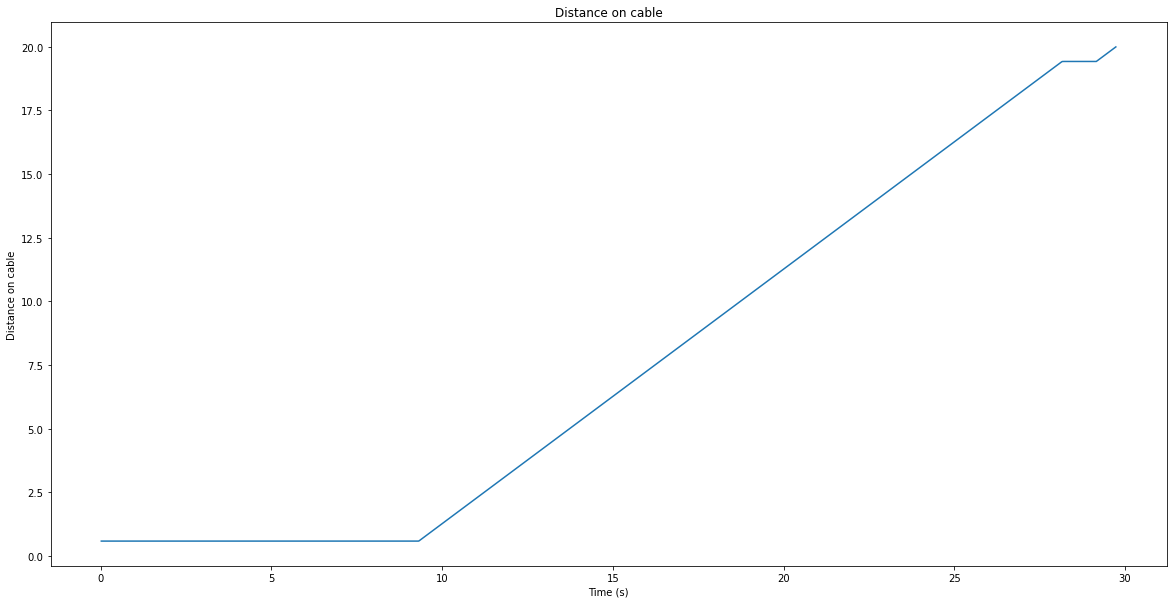

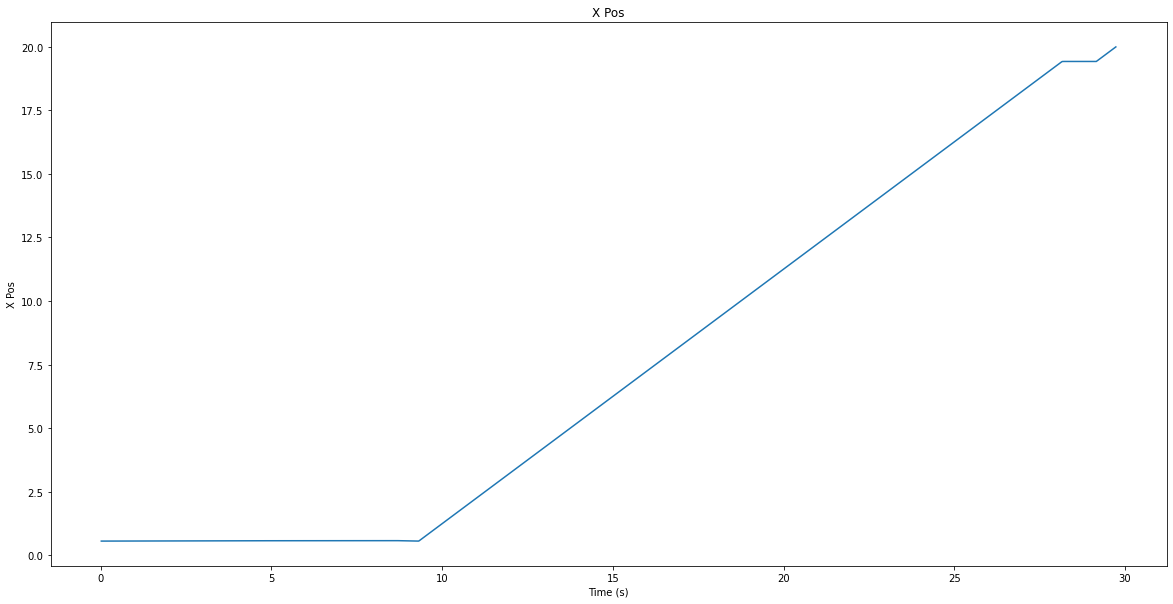

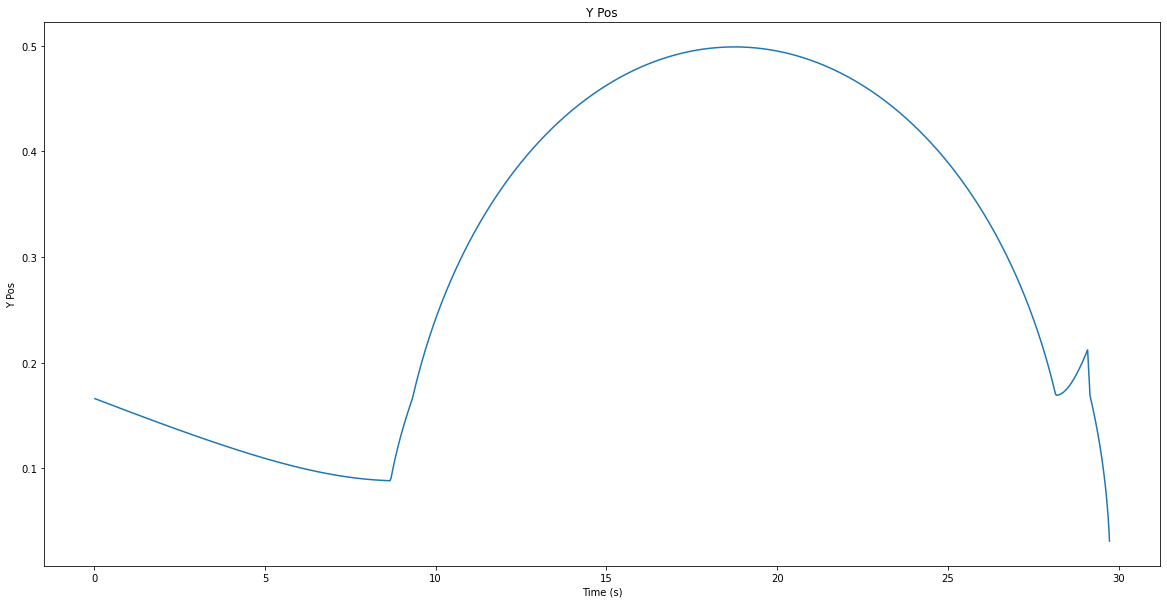

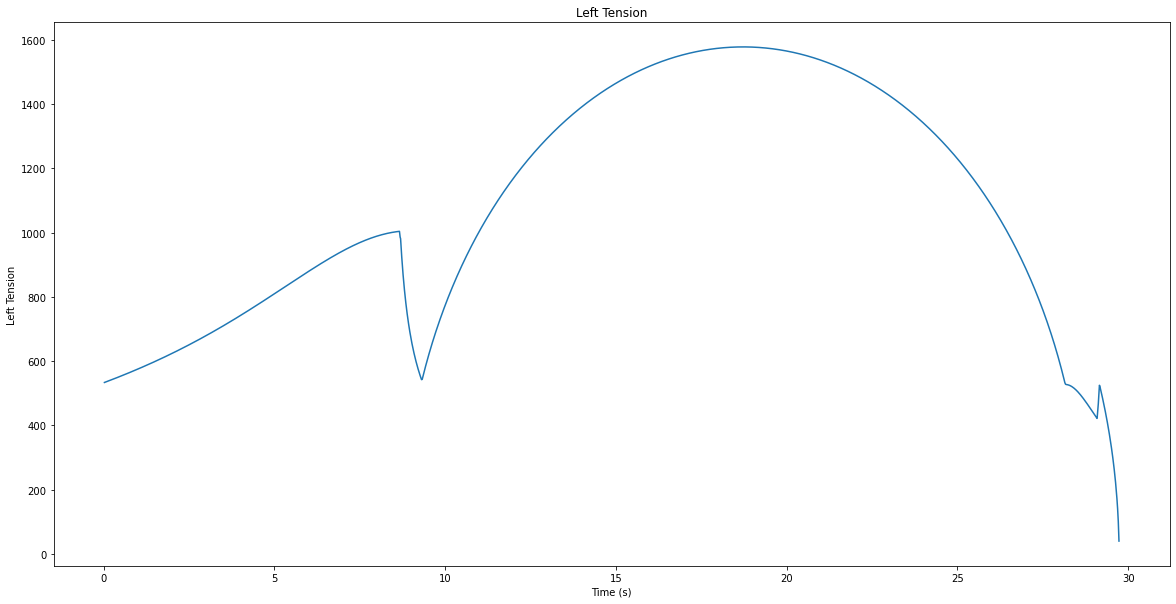

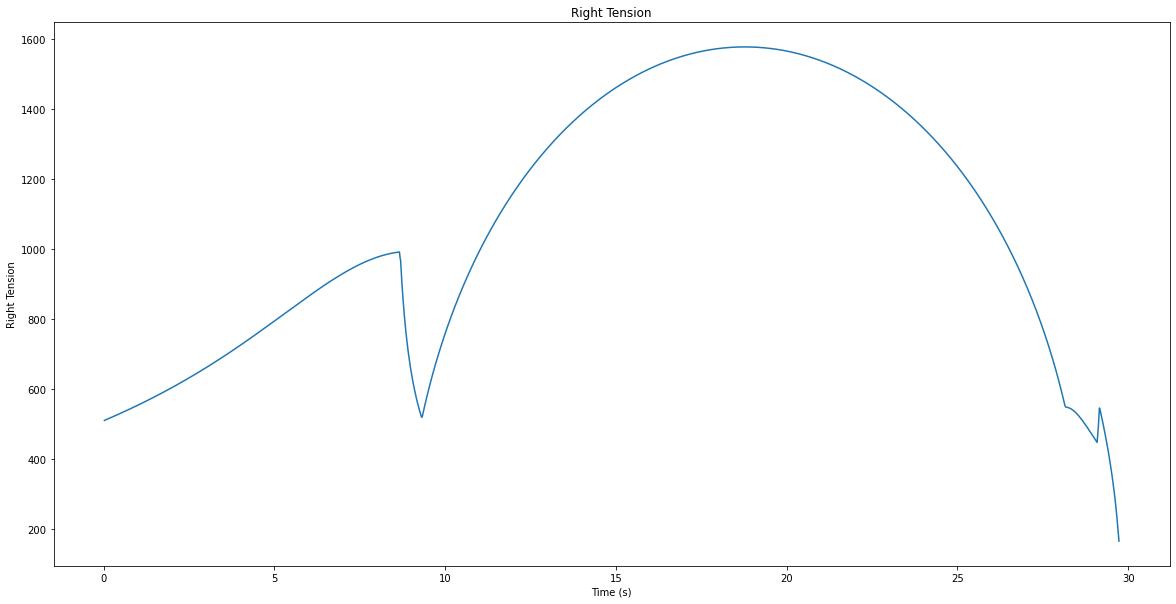

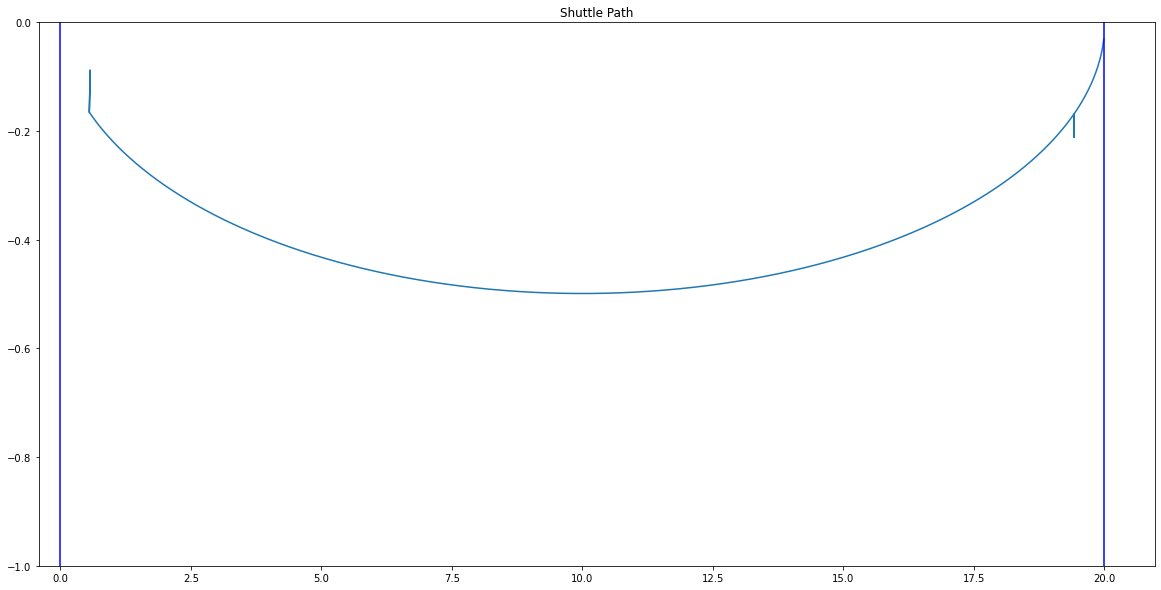

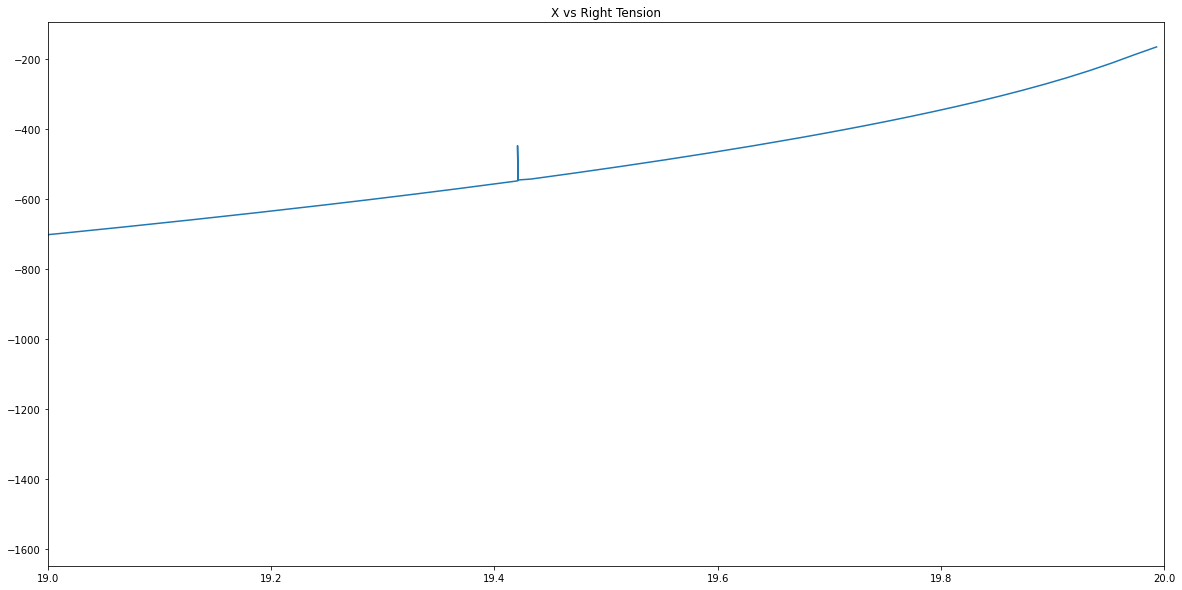

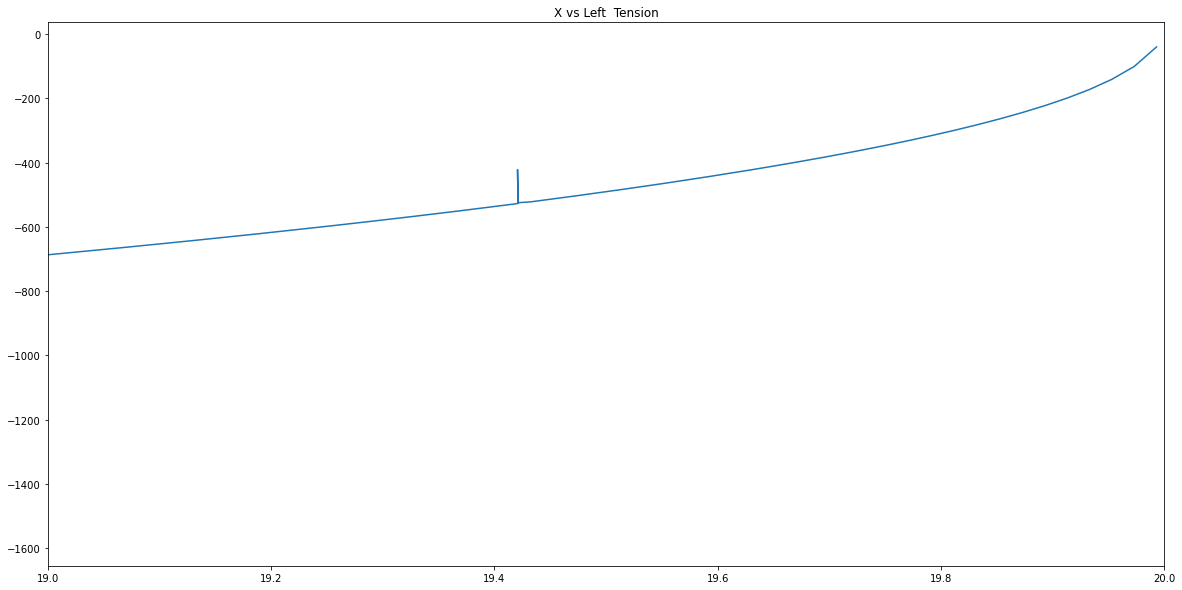

In [522]:
var_list = ["Left arm angle", "Right arm angle", "Takeup", "Distance on cable", "X Pos", "Y Pos", "Left Tension", "Right Tension"]
for state in range(output.shape[1]):
    plt.figure(figsize=(20,10))
    plt.plot(time, output[:, state])
    plt.title(var_list[state])
    plt.xlabel("Time (s)")
    plt.ylabel(f"{var_list[state]}")
    plt.savefig(f"{var_list[state]} for {lencable}m cable over {cablespan}m.png")

plt.figure(figsize=(20,10))
plt.plot(output[:, 4], -1 * output[:, 5])
plt.title("Shuttle Path")
plt.ylim([-1, 0])
plt.axvline(x = 0, color = 'b')
plt.axvline(x = cablespan, color = 'b')
plt.savefig(f"Path for {lencable}m cable over {cablespan}m.png")

plt.figure(figsize=(20,10))
plt.plot(output[:, 4], -1 * output[:, 7])
plt.title("X vs Right Tension")
plt.xlim([19, 20])
plt.figure(figsize=(20,10))
plt.plot(output[:, 4], -1 * output[:, 6])
plt.title("X vs Left  Tension")
plt.xlim([19, 20])

In [519]:
min(output[:, 7])

166.30869839759924

In [508]:
def max_tension(la, ra, lt, rt):
    return (math.e**(0.4 * (la + ra)) - 1) * (lt + rt)

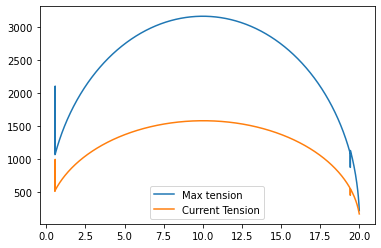

In [512]:
plt.plot(output[:, 4], max_tension(output[:, 0], output[:, 1], output[:, 6], output[:, 7]), label = "Max tension")
plt.plot(output[:, 4], output[:, 7], label="Current Tension")
plt.legend()

Text(0.5, 0, 'X position')

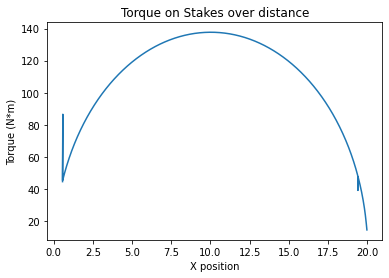

In [411]:
plt.plot(output[:, 4], 2 * output[:, 7] * math.sin(math.radians(5)/2))
plt.title("Torque on Stakes over distance")
plt.ylabel("Torque (N*m)")
plt.xlabel("X position")

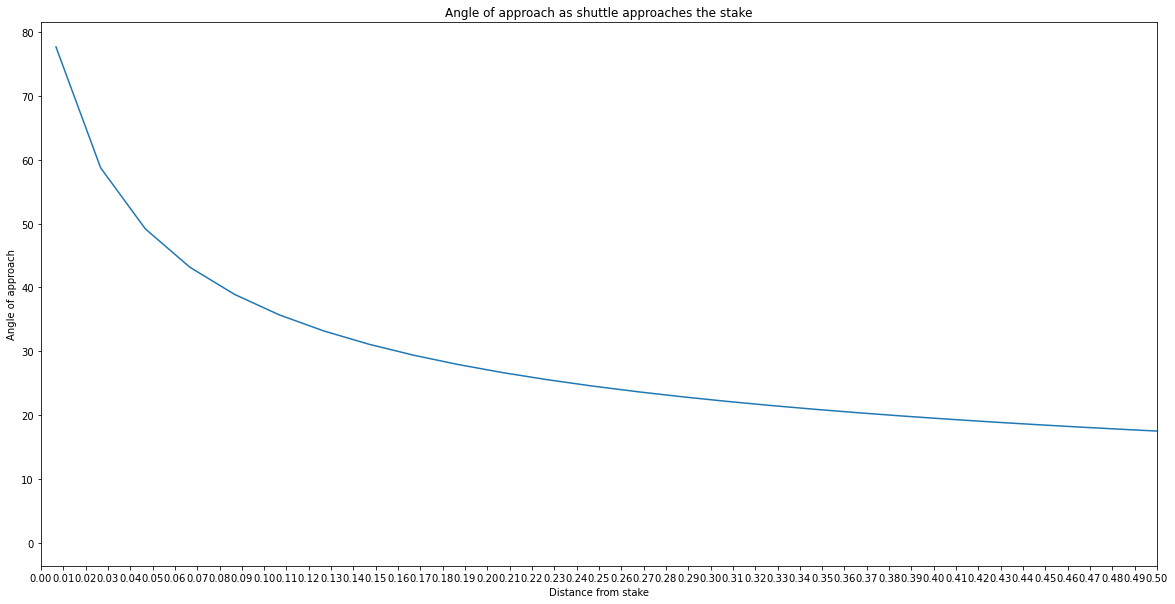

In [506]:
plt.figure(figsize=(20, 10))
plt.plot(cablespan - output[:, 4], np.arctan2(output[:, 5], cablespan - output[:, 4]) * 180/math.pi)
plt.xticks(np.arange(0, 1, .01))
plt.xlim(0, .5)
plt.xlabel("Distance from stake")
plt.ylabel("Angle of approach")
plt.title("Angle of approach as shuttle approaches the stake")
plt.show()

In [487]:
max(output[:, 5])

0.506774354053731

In [507]:
output[-1, 5]

0.030781547535016704

MovieWriter ffmpeg unavailable; using Pillow instead.


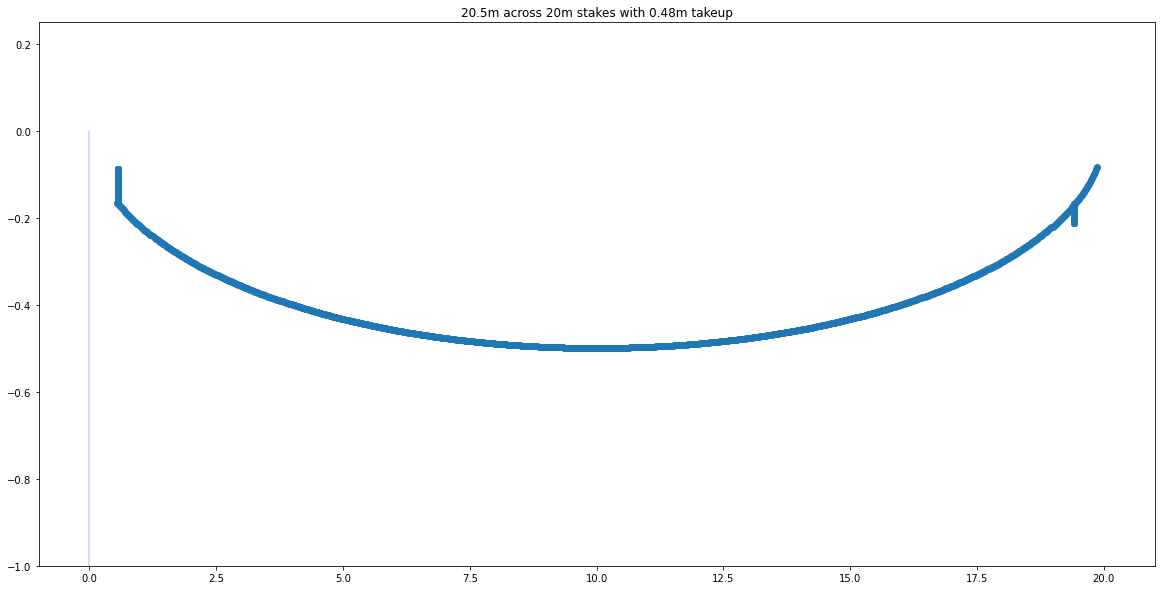

In [410]:
from matplotlib.animation import FuncAnimation
fig = plt.figure(figsize=(20, 10))
plt.xlim(-1, cablespan + 1)
plt.ylim(-1, 0.25)
graph, = plt.plot([], [], 'o')
plt.axvline(x = 0, color = 'b', lw = 0.3, ymax = 0.8)
plt.axvline(x = 25, color = 'b', lw=0.3,  ymax = 0.8)
plt.title(f"{lencable}m across {cablespan}m stakes with {mintakeup:.2f}m takeup")
def animate(i):
    graph.set_data(output[:i*5, 4], -output[:i*5, 5])
    return graph

ani = FuncAnimation(fig, animate, frames=int(len(output)) // 5, interval=20)
ani.save("constanttensioiningtest.gif", fps=60)
plt.show()

In [ ]:
output[1, 4]

In [ ]:
math.sqrt(poscable**2-(cablespan**2+2*poscable*(lencable-takeup)-(lencable-takeup)**2)**2/(4*cablespan**2))